<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Recomendando el Blog de  Hernán Casciari 


[Hernán Casciari](https://hernancasciari.com/#bio), es un escritor argentino, que escribe blog posts con cuentos e historias  relacionadas con el futbol, su vida, infancia, y relaciones familiares con toques de ficción. Este [blog](https://hernancasciari.com/blog/) es  tan interesantes que en 2005 fue premiado como “El mejor blog del mundo” por Deutsche Welle de Alemania. 

El objetivo de este caso-taller es construir un sistema de recomendación basado en los contenidos de los posts utilizando similitud de las palabras usadas o temas de los cuentos.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "Revisión por el compañero."

4. El archivo entregado debe poder ser ejecutado localmente por los pares. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos  en la misma ruta de acceso del cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos 

En la carpeta `data` se encuentran el archivo `blog_casciari.csv` con el título, la fecha de publicación, y el contenido de los cuentos publicados en el blog  de sr. Casciari. Cargue estos datos en su *cuaderno* y reporte brevemente el contenido de la base.
   

In [2]:
import pandas as pd
import numpy as np
import re
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df_blog_raw = pd.read_csv("data/blog_casciari.csv")

print("cantidad de blogs: {}".format(df_blog_raw.shape[0]))


prom_cantidad_palabras_blog = np.round(df_blog_raw["cuento"].apply(lambda x: len(x.split())).mean(),0)
std_cantidad_palabras_blog =  np.round(df_blog_raw["cuento"].apply(lambda x: len(x.split())).std(),0)
max_cantidad_palabras_blog =  df_blog_raw["cuento"].apply(lambda x: len(x.split())).max()
min_cantidad_palabras_blog =  df_blog_raw["cuento"].apply(lambda x: len(x.split())).min()

print("cantidad de caracteres en el blogs mas corto: {}".format(min_cantidad_palabras_blog))
print("cantidad promedio de caracteres en los blog: {}".format(prom_cantidad_palabras_blog))
print("desviacion estandar de cantidad de caracteres en los blog: {}".format(std_cantidad_palabras_blog))
print("cantidad de caracteres en el blogs mas largo: {}".format(max_cantidad_palabras_blog))

df_blog_raw.head(2)

cantidad de blogs: 520
cantidad de caracteres en el blogs mas corto: 95
cantidad promedio de caracteres en los blog: 882.0
desviacion estandar de cantidad de caracteres en los blog: 623.0
cantidad de caracteres en el blogs mas largo: 5603


,titulo,fecha,cuento
0,El rincón blanco,1/11/08,De pronto yo estaba en el hogar donde pasé la ...
1,Mínimos avances en la cama,1/24/08,"Menos la cama, todo ha mejorado en este mundo...."


(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 2. Homogenización de textos

Para cumplir con el objetivo de generar recomendaciones en esta sección debe preparar los posts para poder ser utilizados en su sistema de recomendación. Para ello, "limpie" y "tokenize" cada uno de los cuentos, describiendo detalladamente los pasos que realizo y si transformó o eliminó ciertas palabras. Para asistirlo en la tarea he creado listas de *stopwords* que están disponibles en la carpeta `data`. En su procedimiento ilustre la limpieza con el cuento 'La venganza del metegol'. (En su limpieza recuerde que el objetivo es generar recomendaciones a partir de la similitud de las palabras o temas de los cuentos)

In [4]:
fltr_venganza_metegol = df_blog_raw["titulo"] == "La venganza del metegol"
print(df_blog_raw.loc[fltr_venganza_metegol,"cuento"].values[:200])

['El mes pasado me invitaron a presentar un libro en Buenos Aires. Y como era un libro sobre fútbol, al final de la charla el director de la editorial nos invitó a jugar un partido de metegol (ese invento español al que sus creadores llaman, erróneamente, futbolín). Hacía años que no jugaba al metegol, pero por suerte me tocó de compañero un filósofo muy prestigioso y pudimos ganar. Nuestros contrincantes eran el autor del libro y el director de la editorial. De los tres, a este último lo conocía desde la juventud.\nJugamos dos partidos enteros y los destrozamos con una facilidad pasmosa: hacía años que no practicaba este falso deporte de muñecas y reflejos, pero descubrí que no había perdido las mañas. Eso me hizo sentir bien: a mi edad cualquier destreza que mantengamos indemne, por más pelotuda que sea, se convierte en una gran noticia.\nDespués de la charla algunos fotógrafos hicieron imágenes del partido de metegol y las subieron a Twitter.\n— Estadio: Librería Gandhi, Buenos Aire

In [5]:
nlp = spacy.load("es_core_news_sm")

# se toman los stopwords sugeridos 
extra_stopwords = pd.read_csv('data/extra_stopwords.csv', sep=',',header=None)
extra_stopwords.columns = ['stopwords']
extra_stopwords=set(extra_stopwords['stopwords'].to_list())

# Agregamos a nuestro modelo de SpaCy
nlp.Defaults.stop_words |= extra_stopwords

# se toman mas stopwords sugeridos 
extra_stopwords = pd.read_csv('data/stopwords_taller.csv', sep=',',header=None)
extra_stopwords.columns = ['stopwords']
extra_stopwords=set(extra_stopwords['stopwords'].to_list())

nlp.Defaults.stop_words |= extra_stopwords

In [6]:
def limpieza_texto(texto):
    
    # se eliminan los caracteres especiales del español como tildes
    out = unidecode.unidecode(texto)
    # eliminar caracteres de puntuacion puntos, exclamaciones etc
    out = re.sub("[^\\w\\s]|\n", ' ', out)
    # eliminar digitos
    out = re.sub("\d+", "", out)
    # eliminar los espacios extras 
    out = re.sub('\s+', ' ', out)
    out = out.strip()
    # conversion a minuscula 
    out = out.lower()

    out = nlp(out)
    # Filtrar las stopwords y obtener lemmas
    out = [token.lemma_ for token in out if not token.is_stop and len(token) > 2]
    out = " ".join(out)
    
    # volver a aplicar la limpieza ya que el lemmatizador devuelve algunas palabras con tilde
    out = unidecode.unidecode(out)
        
    return out

In [7]:
lst_blog_clean = list(map(limpieza_texto, df_blog_raw['cuento']))

In [8]:
df_blog_clean = df_blog_raw.copy()
df_blog_clean["cuento_clean"] = lst_blog_clean

In [9]:
fltr_venganza_metegol = df_blog_raw["titulo"] == "La venganza del metegol"
print(df_blog_raw.loc[fltr_venganza_metegol,"cuento"].values[:200])
print(df_blog_clean.loc[fltr_venganza_metegol,"cuento_clean"].values[:200])

['El mes pasado me invitaron a presentar un libro en Buenos Aires. Y como era un libro sobre fútbol, al final de la charla el director de la editorial nos invitó a jugar un partido de metegol (ese invento español al que sus creadores llaman, erróneamente, futbolín). Hacía años que no jugaba al metegol, pero por suerte me tocó de compañero un filósofo muy prestigioso y pudimos ganar. Nuestros contrincantes eran el autor del libro y el director de la editorial. De los tres, a este último lo conocía desde la juventud.\nJugamos dos partidos enteros y los destrozamos con una facilidad pasmosa: hacía años que no practicaba este falso deporte de muñecas y reflejos, pero descubrí que no había perdido las mañas. Eso me hizo sentir bien: a mi edad cualquier destreza que mantengamos indemne, por más pelotuda que sea, se convierte en una gran noticia.\nDespués de la charla algunos fotógrafos hicieron imágenes del partido de metegol y las subieron a Twitter.\n— Estadio: Librería Gandhi, Buenos Aire

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 3. Generando Recomendaciones

En esta sección nos interesa generar recomendaciones de cuentos en el blog a un usuario que leyó 'La venganza del metegol'. Para ello vamos a utilizar distintas estrategias.

#### 3.1. Recomendaciones basadas en contenidos

##### 3.1.1. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para el cuento 'La venganza del metegol' usando en la distancia de coseno donde el texto este vectorizado por `CountVectorizer`. Explique el procedimiento que realizó y como ordenó las recomendaciones.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
count = CountVectorizer()
count_matrix = count.fit_transform(df_blog_clean['cuento_clean'])

#Calculamos la matriz de similitud de coseno
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [12]:
def top_k_recomendaciones(titulo, matriz_pesos, df, k):
        
    # encontrar ubicacion del titulo
    fltr_venganza_metegol = df["titulo"] == titulo
    indx_cuento = np.argmax(fltr_venganza_metegol)

    # determinar la cantidad de sugerencias
    n_sugerencias = k
    # tomar la matriz que tiene los criterios de decision y obtener el top de indices
    top_sugerencias = np.argsort(matriz_pesos[indx_cuento])[-n_sugerencias-1:-1]

    # encontrar las sugerencias en el blog original ordernar de mayor a menor
    sugerencias = df_blog_clean.iloc[top_sugerencias,:][::-1]


    return sugerencias

In [13]:
titulo = "La venganza del metegol"
top_k_recomendaciones(titulo, cosine_sim, df_blog_clean, 5)

,titulo,fecha,cuento,cuento_clean
416,Hace seis años también era domingo,5/14/06,Hace seis años yo vivía en una casita alucinan...,ano vivia casita alucinante miniatura pareciar...
5,El milagro de los pueblos,4/22/08,Cuando nació la Nina no tuve ganas de escribir...,nacio nina gana escribir descubrimiento patern...
17,Cuento con bruja y tramontina,8/29/08,Íbamos en un taxi por la avenida Álvarez Thoma...,ibar taxi avenida alvarez thoma llegar esquina...
121,Gaussian blur,10/10/13,Estoy en San José de Costa Rica y llueve. Acab...,san jo el rico llover acabar pedir cafe abrir ...
519,La madre de todas las desgracias,12/13/07,"Los que vivimos tan lejos, con un Atlántico en...",vivir lejos atlantico tema tabu aterrar saber ...


(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

##### 3.1.2. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para  el cuento 'La venganza del metegol' usando nuevamente la distancia de coseno, pero ahora vectorice el texto usando `TF-IDFVectorizer`. Explique el procedimiento que realizó y como ordenó las recomendaciones. Compare con los resultados del punto anterior y explique sus similitudes y/o diferencias.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [15]:

#Definimos el objeto TF-IDF Vectorizer Object
tfidf = TfidfVectorizer()

#Construimos la matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(df_blog_clean["cuento_clean"])

df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Calculamos el producto punto
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [16]:
titulo = "La venganza del metegol"
top_k_recomendaciones(titulo, cosine_sim, df_blog_clean, 5)

,titulo,fecha,cuento,cuento_clean
17,Cuento con bruja y tramontina,8/29/08,Íbamos en un taxi por la avenida Álvarez Thoma...,ibar taxi avenida alvarez thoma llegar esquina...
121,Gaussian blur,10/10/13,Estoy en San José de Costa Rica y llueve. Acab...,san jo el rico llover acabar pedir cafe abrir ...
519,La madre de todas las desgracias,12/13/07,"Los que vivimos tan lejos, con un Atlántico en...",vivir lejos atlantico tema tabu aterrar saber ...
5,El milagro de los pueblos,4/22/08,Cuando nació la Nina no tuve ganas de escribir...,nacio nina gana escribir descubrimiento patern...
414,La desgracia venía en sobres papel madera,4/27/06,Desde los tres años de edad empecé a desarroll...,ano edad empece desarrollar patologia extrana ...


(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

##### 3.1.3. Genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para el cuento 'La venganza del metegol' usando el texto vectorizado por `TF-IDFVectorizer` y la correlación como medida de similitud. Explique el procedimiento que realizó y como ordenó las recomendaciones. Compare con los resultados de los puntos anteriores y explique sus similitudes y/o diferencias.

In [38]:
corr_matrix = np.corrcoef(df_tfidf.values)

In [39]:
titulo = "La venganza del metegol"
top_k_recomendaciones(titulo, corr_matrix, df_blog_clean, 5)

,titulo,fecha,cuento,cuento_clean
17,Cuento con bruja y tramontina,8/29/08,Íbamos en un taxi por la avenida Álvarez Thoma...,ibar taxi avenida alvarez thoma llegar esquina...
121,Gaussian blur,10/10/13,Estoy en San José de Costa Rica y llueve. Acab...,san jo el rico llover acabar pedir cafe abrir ...
5,El milagro de los pueblos,4/22/08,Cuando nació la Nina no tuve ganas de escribir...,nacio nina gana escribir descubrimiento patern...
519,La madre de todas las desgracias,12/13/07,"Los que vivimos tan lejos, con un Atlántico en...",vivir lejos atlantico tema tabu aterrar saber ...
414,La desgracia venía en sobres papel madera,4/27/06,Desde los tres años de edad empecé a desarroll...,ano edad empece desarrollar patologia extrana ...


(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

##### 3.2. Recomendaciones basadas en temas

Usando modelado de temas con LDA, encuentre los temas subyacentes en el blog. Explique como eligió el numero óptimo de temas. Utilizando el tema asignado al cuento 'La venganza del metegol' y la probabilidad de pertenecer a este tema genere 5 recomendaciones de más recomendada (1) a menos recomendada (5) para este cuento. Explique el procedimiento que realizó. Compare con los resultados encontrados anteriormente y explique sus similitudes y/o diferencias. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


In [57]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from pprint import pprint
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

In [51]:
dictionary = Dictionary(df_blog_clean["cuento_clean"].str.split())

dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(doc) for doc in df_blog_clean["cuento_clean"].str.split()]
print('Numero de palabras únicas: %d' % len(dictionary))

Numero de palabras únicas: 1262


In [52]:
Estimacion = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    chunksize=1000,
    passes=20,
    iterations=400,
    alpha='auto',
    eta='auto',
    random_state=123,
    eval_every=None
)

In [53]:
pprint(Estimacion.print_topics())

[(0,
  '0.009*"yo" + 0.007*"mujer" + 0.007*"hombre" + 0.006*"amigo" + '
  '0.006*"llegar" + 0.005*"nino" + 0.005*"querer" + 0.005*"sueno" + '
  '0.005*"pensar" + 0.005*"mano"'),
 (1,
  '0.014*"caio" + 0.013*"zacaria" + 0.010*"viejo" + 0.009*"nacho" + '
  '0.009*"sofi" + 0.008*"hijo" + 0.008*"chico" + 0.007*"llorar" + '
  '0.007*"venir" + 0.007*"dar"'),
 (2,
  '0.007*"argentino" + 0.007*"escribir" + 0.006*"llamar" + 0.006*"yo" + '
  '0.005*"llegar" + 0.005*"hablar" + 0.005*"pensar" + 0.005*"pais" + '
  '0.005*"amigo" + 0.005*"palabra"')]


In [58]:
def calcular_coherencia(dictionary, corpus, texts, start=1, limit=10, step=1):
 
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=123,
                        passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [66]:
inicio = 1
limite = 15
paso = 1
modelos, valores_c = calcular_coherencia(dictionary=dictionary, corpus=corpus, texts=df_blog_clean["cuento_clean"].str.split(), start=inicio, limit=limite, step=paso)

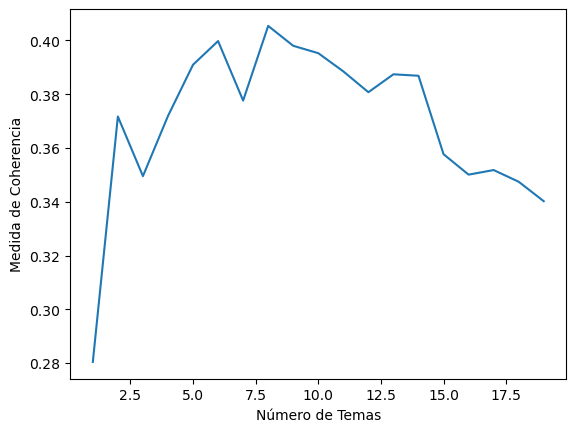

In [75]:
import matplotlib.pyplot as plt
# Show graph
x = range(inicio, limite, paso)
plt.plot(x, valores_c)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Coherencia")
plt.show()

In [77]:
x[np.argmax(valores_c)]

8

In [78]:
def perplejidad_ntemas(dictionary, corpus, texts, start=1, limit=10, step=1):
 
    perplejidad_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=123,
                        passes=20)
        model_list.append(model)
        perplejidad_values.append(np.exp2(-model.log_perplexity(corpus)))

    return model_list, perplejidad_values

In [79]:
modelos, valores_p = perplejidad_ntemas(dictionary=dictionary, corpus=corpus, texts=df_blog_clean["cuento_clean"].str.split(), start=inicio, limit=limite, step=paso)

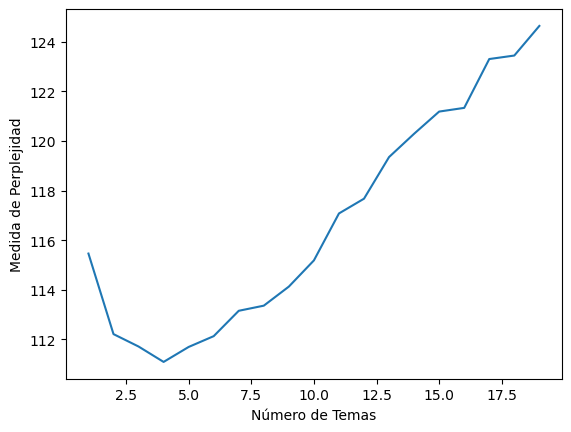

In [81]:
import matplotlib.pyplot as plt
# Show graph
x = range(inicio, limite, paso)
plt.plot(x, valores_p)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Perplejidad")

plt.show()

In [83]:
x[np.argmin(valores_p)]

4

In [135]:
model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=6, 
                        random_state=123,
                        passes=20)

In [136]:
model.print_topics()

[(0,
  '0.015*"yo" + 0.011*"foto" + 0.009*"amigo" + 0.008*"luna" + 0.008*"nino" + 0.008*"enfermera" + 0.007*"hospital" + 0.007*"pensar" + 0.006*"voz" + 0.006*"viejo"'),
 (1,
  '0.019*"caio" + 0.017*"zacaria" + 0.012*"viejo" + 0.012*"nacho" + 0.012*"sofi" + 0.009*"hijo" + 0.008*"chico" + 0.008*"venir" + 0.008*"llorar" + 0.007*"dar"'),
 (2,
  '0.017*"mundial" + 0.017*"futbol" + 0.015*"partido" + 0.013*"argentino" + 0.013*"gol" + 0.009*"jugar" + 0.008*"jugador" + 0.007*"equipo" + 0.007*"pensar" + 0.006*"hijo"'),
 (3,
  '0.011*"hombre" + 0.010*"argentino" + 0.008*"pais" + 0.007*"espana" + 0.006*"morir" + 0.006*"television" + 0.006*"ocurrir" + 0.006*"espanol" + 0.006*"guerra" + 0.005*"muerte"'),
 (4,
  '0.015*"escribir" + 0.008*"leer" + 0.008*"palabra" + 0.008*"llamar" + 0.007*"amigo" + 0.007*"lector" + 0.007*"historia" + 0.006*"blog" + 0.006*"persona" + 0.006*"yo"'),
 (5,
  '0.010*"yo" + 0.009*"mujer" + 0.007*"llegar" + 0.006*"mano" + 0.006*"tenia" + 0.006*"ir" + 0.005*"dar" + 0.005*"saber

In [130]:
# for word,idx in dictionary.token2id.items():
#     print(word,idx)

In [108]:
df_blog_clean.iloc[160,:]["cuento_clean"]

'mes invitar presentar aires futbol char el director editorial invitar jugar partido metegol invento espanol creador llamar erroneamente futbolin ano jugar metegol suerte tocar companero filosofo prestigioso poder ganar contrincante autor director editorial conocia juventud jugar partido entero destrozar facilidad pasmos ano practicar falso deporte muneca reflejo descubri perdido mana sentir edad destreza mantengar indemne pelotuda convertir noticia char el fotografo imagen partido metegol subir twitter estadio librerio gandhi aire local izquierda duchini gonzalo garz vistant derecha tomar abraham resultado match match palizar volvi recibi mail amigo infancia deciar visto foto sorprendiar companero filosofo admirabar juventud jugar metegol toma abraham pasar sueno deciar partido imagine diecisiete ano mirar ventana libreria gandhi escena futuro sonrei recuerdo momentaneo desconcentro juego justo gol unico recibi defendiar zaga gol molinete gonzalo garz director editorial galerno injust

In [137]:
l=[model.get_document_topics(item) for item in corpus]
#pd.DataFrame(l)
dicts_topicos = [{k: v for k, v in row} for row in l]

# Create a DataFrame from the list of dictionaries
df_proba_topicos_lda = pd.DataFrame(dicts_topicos)

In [148]:
df_proba_topicos_lda.iloc[160,:]#.idxmax()#sort_values(ascending=False)

4    0.087789
5    0.669227
0         NaN
2    0.240828
3         NaN
1         NaN
Name: 160, dtype: float64

In [145]:
df_proba_topicos_lda.sort_values(by=5, ascending=False).index[:5]

Index([6, 17, 382, 462, 0], dtype='int64')

In [147]:
df_blog_clean.iloc[[6, 17, 382, 462, 0]]

,titulo,fecha,cuento,cuento_clean
6,Ropa sucia,5/6/08,Ya de entrada caí mal parado. Vine al mundo ju...,entrada cai parado venir justo ano pobre costu...
17,Cuento con bruja y tramontina,8/29/08,Íbamos en un taxi por la avenida Álvarez Thoma...,ibar taxi avenida alvarez thoma llegar esquina...
382,Una docena de tortas negras,5/19/05,Miró a las tres mujeres que esperaban que cort...,mirar mujer esperar cortasar semaforo morocha ...
462,El miedo,2/14/07,El miedo es un animal dormido que tengo dentro...,miedo animal dormido animal blanco desconfiado...
0,El rincón blanco,1/11/08,De pronto yo estaba en el hogar donde pasé la ...,hogar infancia saber nariz acostumbrar penumbr...


In [ ]:
lda_model_opt = LdaMulticore(corpus = corpus,
    id2word = dictionary,
    num_topics = 8,
    random_state=123)
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(lda_model_opt, corpus, dictionary)
LDA_visualization

In [167]:
topicos_titulo

Index([4, 5, 2], dtype='int64')

In [166]:
fltr_condicion = df_proba_topicos_lda.iloc[160,:].isna()
topicos_titulo = df_proba_topicos_lda.columns[~fltr_condicion]

idx_sugerencias_lda = df_proba_topicos_lda.loc[:,topicos_titulo].sum(axis=1).sort_values(ascending=False)[:5].index
df_blog_clean.iloc[idx_sugerencias_lda,:]

,titulo,fecha,cuento,cuento_clean
6,Ropa sucia,5/6/08,Ya de entrada caí mal parado. Vine al mundo ju...,entrada cai parado venir justo ano pobre costu...
117,10.6 segundos,1/29/13,"Menos de once segundos antes, cuando el jugado...",segundo jugador argentino recibir companero re...
110,El segundo cajón,6/13/11,Resulta que no hace mucho publiqué en este blo...,resultar publique blog historia amor ocurrir a...
15,Backstage de un milagro menor,8/11/08,Voy a contar algo que ocurrió hace un mes y qu...,contar ocurrio mes parecer milagro entrecasa n...
353,Lado A: música ligera,8/24/04,El mismo día que a Maradona lo echaron del Mun...,maradona echar mundial cansir comprar olivetti...


In [165]:
idx_sugerencias_lda

Index([6, 117, 110, 15, 353], dtype='int64')

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 4 Recomendaciones generales

De acuerdo con los resultados encontrados, en su opinión ¿qué procedimiento generó las mejores recomendaciones para la entrada elegida? ¿Cómo implementaría una evaluación objetiva de estas recomendaciones? Justifique su respuesta.

(Utilice este espacio para describir su procedimiento)